### Slideflow Tutorial Notebook: Feature Extraction, UMAP Visualization, MIL Classifier
This notebook is designed to take users through:<br>
1. [Importing a Slideflow Project](#import)
    - [Tile Extraction](#tile)<br>
2. [Feature Extraction](#fe)
    - [Pre-Trained Feature Extraction](#pre-fe)<br>
3. [Feature Visualization](#feature_viz)
    - [UMAP Visualization](#umap_viz)<br>
4. [Training an SSL model Feature Extraction](#ssl-fe)<br><br>
5. [Training an MIL Model](#mil) *Not done* <br><br>
6. [Classifier Result Visualization](#class_viz) *Not done* 
    - [Custom AUROC](#auroc)
    - [Confusion Matrix](#cmat)

<a id='import'></a>
### Import libraries

Always the first step.

In [1]:
# Set environment variables with os package
import os
os.environ['SF_BACKEND'] = 'torch' # Alternative is 'tensorflow'
os.environ['SF_SLIDE_BACKEND'] = 'cucim' # Alternative is 'libvips'
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Set which GPU(s) to use 

# Check if GPU is available
if os.environ['SF_BACKEND']=='torch':
    import torch
    print('GPU available: ', torch.cuda.is_available())
    print('GPU count: ', torch.cuda.device_count())
    print('GPU current: ', torch.cuda.current_device())
    print('GPU name: ', torch.cuda.get_device_name(torch.cuda.current_device()))
elif os.environ['SF_BACKEND']=='tensorflow':
    import tensorflow as tf
    print("GPU: ", len(tf.config.list_physical_devices('GPU')))

# import slideflow
import slideflow as sf

# Set verbose logging
import logging
logging.getLogger('slideflow').setLevel(logging.INFO)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '10'
import sys
sys.stderr = sys.__stdout__

# Check if slideflow was properly installed
sf.about()

GPU available:  True
GPU count:  1
GPU current:  0
GPU name:  NVIDIA A100-PCIE-40GB


╭───────────────────────╮                                                                                          
│ Slideflow             │                                                                                          
│ Version: 3.0.1        │                                                                                          
│ Backend: torch        │                                                                                          
│ Slide Backend: cucim  │                                                                                          
│ https://slideflow.dev │                                                                                          
╰───────────────────────╯

<a id='project'></a>
### Getting Started with a Slideflow Project

This tutorial assumes that you have already created a project folder. Once the project has been created and you have specified the paths to datasets, annotation files, etc. we will begin by initializing a Slideflow Project object.

In [4]:
# Set root paths
username = "skochanny" # change me
root_path = f'/scratch/{username}/PROJECTS'
labshare_path = '/gpfs/data/pearson-lab/'
project_name = "TEST_PROJECT"
project_root_path = f"{root_path}/{project_name}"

# # Initialize the Project class object
P = sf.Project(project_root_path)

<a id='tile'></a>
#### Tile Extraction (If Needed)

Once the project and dataset have been specified, we can extract tiles from the whole slide images. If this step has already been completed, you can skip this section.<br><br>
Notes regarding tile extraction:<br>
- If you do not have manually annotated ROIs, the image will be tiled. If taking this route, be sure to edit the `whitespace_fraction` parameter such that tiles that are mostly white space are not included in the analysis. You can check the extraction report to see this. 
- If you do have manually annotated ROIs, you can force the tile extration to be only within the ROIs by setting `roi_method='inside'` 
- `qc` is a quality control parameter that will remove tiles based on blur detection and/or otsu's method<br>

Additional parameters for tile extraction can be found in the [Slideflow documentation here](https://slideflow.dev/dataset/#slideflow.Dataset.extract_tiles). 


In [10]:
from slideflow.slide import qc
P.extract_tiles(tile_px=224, # 224x224 pixel tiles are default for most feature extractors
                tile_um=224, 
                whitespace_fraction=0.95,
                roi_method='inside',
                source = ['LUADvsLUSC'],
                qc=[qc.Gaussian(), qc.Otsu()])

[12:42:16] INFO     Slide reading backend: cucim

           INFO     Filtering tiles by grayspace fraction

           INFO     Working on dataset source LUADvsLUSC...

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

           INFO     Extracting tiles from 10 slides (tile_px=299, tile_um=302)

           INFO     Using 4 processes (pool=fork)

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[12:42:23] INFO     Performing Gaussian blur filter at mpp=4.040

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

 cuInit Failed, error CUDA_ERROR_NOT_INITIALIZED
 cuFile initialization failed
 cuInit Failed, error CUDA_ERROR_NOT_INITIALIZED
 cuFile initialization failed
 cuInit Failed, error CUDA_ERROR_NOT_INITIALIZED
 cuFile initialization failed
 cuInit Failed, error CUDA_ERROR_NOT_INITIALIZED
 cuFile initialization failed


[12:42:30] INFO     Finished tile extraction for TCGA-85-8350 (761 tiles of 761 possible)

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

           INFO     Performing Gaussian blur filter at mpp=4.040

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[12:42:49] INFO     Finished tile extraction for TCGA-NC-A5HG (1534 tiles of 1534 possible)

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[12:42:50] INFO     Performing Gaussian blur filter at mpp=4.040

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[12:43:05] INFO     Finished tile extraction for TCGA-55-1594 (1965 tiles of 1965 possible)

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

           INFO     Performing Gaussian blur filter at mpp=4.040

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[12:43:09] INFO     Finished tile extraction for TCGA-75-7027 (758 tiles of 758 possible)

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

           INFO     Performing Gaussian blur filter at mpp=4.040

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[12:43:15] INFO     Finished tile extraction for TCGA-38-4631 (666 tiles of 666 possible)

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

           INFO     Performing Gaussian blur filter at mpp=4.040

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[12:43:18] INFO     Finished tile extraction for TCGA-85-A4CL (624 tiles of 624 possible)

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

           INFO     Performing Gaussian blur filter at mpp=4.040

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[12:43:22] INFO     Finished tile extraction for TCGA-49-4487 (695 tiles of 695 possible)

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

           INFO     Performing Gaussian blur filter at mpp=4.040

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[12:43:28] INFO     Finished tile extraction for TCGA-78-8662 (1598 tiles of 1598 possible)

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

           INFO     No ROI for TCGA-21-5782-01Z-00-DX1.E0C856C0-9055-4437-9393-695D699E4F57, using whole slide.

           INFO     Performing Gaussian blur filter at mpp=4.040

[12:43:39] INFO     Finished tile extraction for TCGA-21-5782 (1176 tiles of 1178 possible)

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

           INFO     Performing Gaussian blur filter at mpp=4.040

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[12:44:01] INFO     Finished tile extraction for TCGA-18-3415 (3303 tiles of 3303 possible)

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

           INFO     Generating PDF (this may take some time)...

/tmp/ipykernel_26559/2302273674.py:2: DeprecationWarning: Substituting font arial by core font helvetica - This is deprecated since v2.7.8, and will soon be removed
  P.extract_tiles(tile_px=299, # 224
/tmp/ipykernel_26559/2302273674.py:2: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=1 use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  P.extract_tiles(tile_px=299, # 224
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
/tmp/ipykernel_26559/2302273674.py:2: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=0 use new_x=XPos.RIGHT, new_y=YPos.TOP.
  P.extract_tiles(tile_px=299, # 224
/tmp/ipykernel_26559/2302273674.py:2: DeprecationWarning: Substituting font arial by core font helvetica - This is d

/gpfs/data/pearson-lab/PERSONAL/skochanny/.conda/envs/sf/lib/python3.9/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Updating CSV for 10 reports.


{'/gpfs/data/pearson-lab/DL_OTHER/TEST_PROJECTS/lung-adeno-v-squam/slides/TCGA-85-8350-01Z-00-DX1.F9A32453-2E24-4874-A1FA-67B4173ABF03.svs': <slideflow.slide.report.SlideReport at 0x7f40c36833a0>,
 '/gpfs/data/pearson-lab/DL_OTHER/TEST_PROJECTS/lung-adeno-v-squam/slides/TCGA-NC-A5HG-01Z-00-DX1.129E83E5-1C4D-4B31-8750-64D10A65267F.svs': <slideflow.slide.report.SlideReport at 0x7f40a80838e0>,
 '/gpfs/data/pearson-lab/DL_OTHER/TEST_PROJECTS/lung-adeno-v-squam/slides/TCGA-55-1594-01Z-00-DX1.bd90c500-7c0b-4c45-a3f7-2d9177384b1d.svs': <slideflow.slide.report.SlideReport at 0x7f40a80abca0>,
 '/gpfs/data/pearson-lab/DL_OTHER/TEST_PROJECTS/lung-adeno-v-squam/slides/TCGA-75-7027-01Z-00-DX1.AC91B34F-DF67-4F95-B145-079A71A54E83.svs': <slideflow.slide.report.SlideReport at 0x7f40a80ab940>,
 '/gpfs/data/pearson-lab/DL_OTHER/TEST_PROJECTS/lung-adeno-v-squam/slides/TCGA-38-4631-01Z-00-DX1.5e0c873a-9c4c-4e0b-bf2e-e3cd8b760761.svs': <slideflow.slide.report.SlideReport at 0x7f40a80d1dc0>,
 '/gpfs/data/pe

<a id='fe'></a>
## Feature Extraction


1. Create/load the dataset
2. Create a feature extractor object (either [SSL](#ssl-feature-extraction-model-training) or [Pre-Trained](#pre-trained-feature-extraction))
3. Calculate and export features

See [Generating features](https://slideflow.dev/features/) in Slideflow's documentation for more information.

To initialize a [Dataset object](https://slideflow.dev/dataset/), you can use the Project object's `dataset()` method. 

In [7]:
# Load the dataset
ad_sq = P.dataset(tile_px=224, tile_um=224)

# Get a summary of the dataset
ad_sq.summary()

In some situations, you may want to perform analysis only on a subset of images within a single dataset. You can filter a dataset by a specific feature of the annotation file with `Dataset.filter()`.

In [6]:
# Filter by site. Sites included in the filter will be included in the dataset
# This is an example of filtering, for the purposes of this tutorial, we will not filter
filter_ad_sq = ad_sq.filter({'site': ['Site-97', 'Site-40', 'Site-9', 'Site-177', 'Site-130', 'Side-69', 'Site-67', 'Site-93', 'Site-96']})

#### Pre-Trained Feature Extraction

Pre-trained feature extraction is very fast! This is because no model training occurs during feature extraction. The model has already been trained and we are simply passing our images through this network to extract features. 

[Here is the list](https://slideflow.dev/features/#pretrained-extractors) of all available pre-trained feature extractors in Slideflow. Some are not available in the base ```slideflow``` package because they require additional dependencies allowing for non-commercial options.

Some notes:
- We can access the extracted features by initializing a [DatasetFeatures](https://slideflow.dev/dataset_features/) class object. 
- It is fine to extract tiles at a different resolution than what is needed for feature extraction (usually 224px). The feature extractor will resize the tiles to the correct resolution with the `resize` parameter.
- After you have generated the features aka feature bags, you want to save them as torch tensors to access later for MIL.

In [ ]:
# TODO: update from .pkl to .bin paths
# Set extractor
extractor_name = 'virchow'
# Define a path for a .pkl file to save the features to:
cache_name = f'{project_root_path}/features/{extractor_name}.pkl'

# print(sf.model.list_extractors()) # to see all available feature extractors

# Create the feature extractor (uncomment the extractor you would like to use)
# phikon = build_feature_extractor('phikon', tile_px=224)
# plip = build_feature_extractor('plip', tile_px=224)
# ctranspath = build_feature_extractor('ctranspath', tile_px=224)
# retccl = build_feature_extractor('retccl', tile_px=224)
virchow = sf.model.build_feature_extractor('virchow', tile_px=224)
extractor = virchow

# initialize the dataset features object
features = sf.DatasetFeatures(extractor, ad_sq, resize=True, cache=cache_name) # you can also use a normalizer on the features: normalizer='reinhard'

# Save feature bags as torch tensors to access them later for MIL
features.to_torch(project_root_path + f'/features/{extractor_name}/torch')

In [ ]:
# NOTE: you can either save features at /features or at /pt_files
# for train_mil(bags=...)
# bags (str) – Either a path to directory with *.pt files, or a list of paths to 
# individual *.pt files. Each file should contain exported feature vectors, 
# with each file containing all tile features for one patient.
# bags=project_root_path + f'/features/{extractor_name}/torch'

*Alternatively*, at a project level, you can also generate the features and save them in one step with `P.generate_feature_bags()`

In [ ]:
# Calculate & export feature bags.
P.generate_feature_bags(extractor, ad_sq)

#### UMAP Visualization

It is useful to visualize the features in a lower-dimensional space. We can use UMAP for this. We'll load in features, calculate UMAP activations, and save. 

Also see Slideflow documentation on [feature space analysis](https://slideflow.dev/posthoc/) for more info and techniques.

In [ ]:
features = sf.DatasetFeatures(virchow, ad_sq, cache=f'{project_root_path}/features/{extractor_name}.pkl')
umap_cache = f'{project_root_path}/cohort/umap'
umap = features.map_activations(n_neighbors=15, min_dist=0.5)
labels, _ = ad_sq.labels('cohort', format='name')
print(labels)
umap.label_by_slide(labels)
umap.save(umap_cache, 
        xlabel='UMAP1',
        ylabel='UMAP2',
        title = f'{extractor_name} Features LUAD vs. LUSC',
        legend='Subtype',
        subsample=5000,
        s=6)

Load in UMAP activations as Slideflow [SlideMap](https://slideflow.dev/slidemap/) object.

[16:25:23] INFO     Loaded coordinates from                                                                        
                    /home/ecdyer/labshare/DL_OTHER/TEST_PROJECTS/TEST_PROJECT/umap/cohort/slidemap.parquet

Thu Dec 21 16:25:26 2023 Building and compiling search function


[16:25:28] INFO     Loaded UMAP from /home/ecdyer/labshare/DL_OTHER/TEST_PROJECTS/TEST_PROJECT/umap/cohort/umap.pkl

           WARNING  Could not find range_clip.npz; results from umap_transform() will not be normalized.

{'TCGA-18-3415-01Z-00-DX1.8C62F2CD-4A2F-4D1E-A662-D7D5AFE557AB': 'Site-97', 'TCGA-21-5782-01Z-00-DX1.E0C856C0-9055-4437-9393-695D699E4F57': 'Site-40', 'TCGA-85-8350-01Z-00-DX1.F9A32453-2E24-4874-A1FA-67B4173ABF03': 'Site-9', 'TCGA-85-A4CL-01Z-00-DX1.05BC31FF-3B88-489F-9BD2-5B2B31C72EDB': 'Site-9', 'TCGA-NC-A5HG-01Z-00-DX1.129E83E5-1C4D-4B31-8750-64D10A65267F': 'Site-177', 'TCGA-38-4631-01Z-00-DX1.5e0c873a-9c4c-4e0b-bf2e-e3cd8b760761': 'Site-130', 'TCGA-49-4487-01Z-00-DX1.3a3a0720-463c-430e-849b-e2f8991bdfa5': 'Site-69', 'TCGA-55-1594-01Z-00-DX1.bd90c500-7c0b-4c45-a3f7-2d9177384b1d': 'Site-67', 'TCGA-75-7027-01Z-00-DX1.AC91B34F-DF67-4F95-B145-079A71A54E83': 'Site-93', 'TCGA-78-8662-01Z-00-DX1.754A4C57-B5FA-4077-99E4-F6EFA6459410': 'Site-96'}


[16:25:29] INFO     Saved 2D UMAP to                                                                               
                    /home/ecdyer/labshare/DL_OTHER/TEST_PROJECTS/TEST_PROJECT/umap/site/umap_site.png

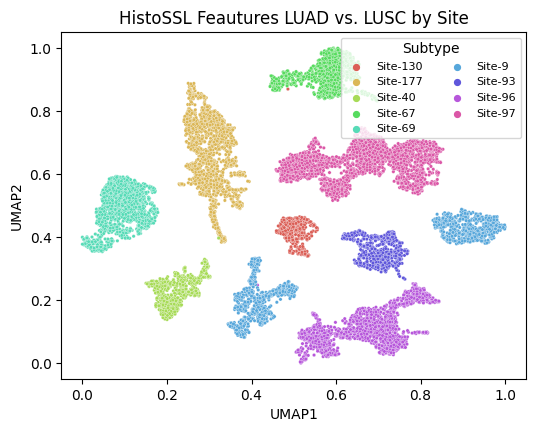

In [25]:
umap = sf.SlideMap.load(f'{project_root_path}/umap/cohort')
save_path = f'{project_root_path}/umap/site/umap_site.png'
labels, _ = ad_sq.labels('site', format='name')
print(labels)
umap.label_by_slide(labels)
umap.save_plot(save_path,
                xlabel='UMAP1',
                ylabel='UMAP2',
                title= f'{extractor_name} Features LUAD vs. LUSC by Site',
                legend='Subtype',
                subsample=12000,
                loc='upper right',
                ncol=2,
                legend_kwargs={'fontsize':8,'markerscale':0.7,'frameon':True,'title_fontsize':10},
                s=6)

# legend_kwargs={'fontsize':8,'markerscale':0.7,'frameon':False,'title_fontsize':10},

## Custom SSL Feature Extraction Model Training

*Note: Training an SSL model requires big GPUs and a lot of data & memory, you probably cannot do it in a Jupyter Notebook.*

SSL feature extraction requires first building a model. This model tries to learn information about the dataset without any human labels; then, we are able to use this model as our now pre-trained featuer extractor. Currently, Slideflow is integrated with two SSL models, SimCLR and DinoV2.<br><br>

#### DinoV2 Overview <br>

1. Install DinoV2
2. Create a DinoV2 config file
3. Train DinoV2 with the commandline interface

DinoV2 requires a `config.yaml` file to be specified. Here is an example of what this file should look like:
```

train:
  dataset_path: slideflow
  batch_size_per_gpu: 32
  slideflow:
    project: "/mnt/data/projects/TCGA_THCA_BRAF"
    dataset:
      tile_px: 299
      tile_um: 302
      filters:
        brs_class:
        - "Braf-like"
        - "Ras-like"
    seed: 42
    outcome_labels: "brs_class"
    normalizer: "reinhard_mask"
    interleave_kwargs: null
```
More information on DinoV2 configuration can be found [here](https://slideflow.dev/ssl/#training-dinov2)<br><br>

In [ ]:
# Download DinoV2
! pip install git+https://github.com/jamesdolezal/dinov2.git
# OR you can clone the repository 

Create a YAML file, modifying the contents as needed: <br>
```
train:
  dataset_path: slideflow
  batch_size_per_gpu: 32
  slideflow:
    project: "/home/ecdyer/labshare/DL_OTHER/TEST_PROJECTS/TEST_PROJECT/"
    dataset:
      tile_px: 299
      tile_um: 302
      filters:
        cohort:
        - "LUSC"
        - "LUAD"
    seed: 42
    outcome_labels: "cohort"
    normalizer: "reinhard_mask"
    interleave_kwargs: null
```
<br><br>
Train DinoV2 with the commandline interface:<br>
```
torchrun --nproc_per_node=4 -m "dinov2.train.train" \
    --config-file /path/to/config.yaml \
    --output-dir /path/to/output_dir
```

#### SimCLR Overview

*Note: Training SimCLR requires tensorflow.*
1. Define SimCLR parameters
2. Train SimCLR

In [ ]:
simclr_args = simclr.get_args(
    mode='train',
    train_mode='pretrain',
    train_batch_size=256,
    temperature=0.1,
    learning_rate=0.075,
    learning_rate_scaling='sqrt',
    weight_decay=1e-4,
    train_epochs=100,
    image_size=299,
    checkpoint_epochs=20)

P.train_simclr(simclr_args, ad_sq, normalizer = 'reinhard_mask')

#### Feature extraction

Once models have trained, you can build a feature extractor for each model and extract the features. To save the features, define a path to save a `.pkl`file with the features.

In [ ]:
# SimCLR Feature Extraction
cache_name = f'{project_root_path}/features/simclr.pkl'

simclr_extractor = build_feature_extractor('simclr', ckpt=f'{project_root_path}/simclr/00006-simclr/ckpt-116420.ckpt')
simclr_features = sf.DatasetFeatures(simclr_extractor, ad_sq, cache=cache_name)

In [ ]:
# Dinov2 Feature Extraction
cache_name = f'{project_root_path}/features/dinov2.pkl'
dinov2 = build_feature_extractor(
    'dinov2',
    weights='/path/to/teacher_checkpoint.pth',
    cfg='/path/to/config.yaml')
dinov2_features = sf.DatasetFeatures(dinov2, ad_sq, cache=cache_name)